# Extracting eccentricity and mchirp samples 
                                             (Rahul Dhurkunde)
#### This notebook extracts samples from a given PDF or CDF functions passed as a .txt file. It can also compute the evolution of eccentricity as a function of frequency as per eqns derived in [Peters and Matthews](https://journals.aps.org/pr/abstract/10.1103/PhysRev.136.B1224).

In [1]:
import pycbc
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from pycbc import conversions
from scipy.stats import loguniform, gaussian_kde, rv_histogram
from scipy.interpolate import interp1d
from scipy.integrate import trapz, cumtrapz, quad, odeint
import scipy.optimize as opt
import pandas as pd
from random import choices
from collections import Counter
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from decimal import Decimal

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
plt.style.use('dark_background')

mpl.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 18

In [2]:
# units
c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30

g3_c5=G**3/c**5; GM_pi2 = G*MS/np.pi**2; parsec = 3.086e+16; au = 1.496e+11; sunr= 6.957e+8 #696340

In [3]:
model_keys = {'belzynscki': 'Belczynski et al. (2018a) (globular cluster)',
               'sedda': 'Arca Sedda (2020b) (globular cluster)',
               'trani': 'Trani et al. (2021) (triples)',
               'fragione': 'Fragione et al. (2019) (nuclear cluster)'
                }

# Functions to generate samples
### There are functions to obtain samples from a given PDF or CDF.
Use the __log_  or __linear_ functions if the parameter axis is in log or linear axis respectively.

In [4]:
#xmin and xmax are without log
def obtain_samples_from_cdf_log(xmin, xmax, filename, spacing):
    points = np.loadtxt(filename, delimiter=',')
    
    points_sort = points[points[:,0].argsort()]
    boolean = points_sort[:,0] < xmax
    xvals = points_sort[boolean]
    
    xvals[:,0] = np.log10(xvals[:,0])
    xvals_pad = xvals

    x_interp = interp1d(xvals_pad[:,0], xvals_pad[:,1], fill_value='extrapolate')
    x_grid = np.arange(np.log10(xmin), np.log10(xmax), spacing)
    
    points_res_cum = np.stack((x_grid, x_interp(x_grid))).T
    
    tolerance = 0.0001
    samples = []
    for i in tqdm(range(len(x_grid))):
        rr = np.random.uniform(0, 1, 1)[0]
        boolean = points_res_cum[:,1] - rr >= tolerance
        try:
            samples.append((points_res_cum[boolean][0, 0]))
        except:    
            None
    samples = np.array(samples)
    return x_grid, x_interp, samples

def obtain_samples_from_cdf_linear(xmin, xmax, filename, spacing):
    points = np.loadtxt(filename, delimiter=',')
    
    points_sort = points[points[:,0].argsort()]
    boolean = points_sort[:,0] < xmax
    xvals = points_sort[boolean]
    
    xvals_pad = xvals

    x_interp = interp1d(xvals_pad[:,0], xvals_pad[:,1], fill_value='extrapolate', kind='linear')
    x_grid = np.arange(xmin, xmax, spacing)
    
    points_res_cum = np.stack((x_grid, x_interp(x_grid))).T
    
    tolerance = 0.0001
    samples = []
    for i in tqdm(range(len(x_grid))):
        rr = np.random.uniform(0, 1, 1)[0]
        boolean = points_res_cum[:,1] - rr >= tolerance
        try:
            samples.append((points_res_cum[boolean][0, 0]))
        except:    
            None
    samples = np.array(samples)
    return x_grid, x_interp, samples


def obtain_samples_from_pdf_log(xmin, xmax, filename, spacing):
    points = np.loadtxt(filename, delimiter=',')
    
    points_sort = points[points[:,0].argsort()]
    boolean = points_sort[:,0] < xmax
    xvals = points_sort[boolean]
    
    xvals[:,0] = np.log10(xvals[:,0])
    zerval_right = np.array([[np.log10(xmax),0]])
    zerval_left = np.array([[np.log10(xmin-0.1*xmin),0]])
    xvals_pad = np.concatenate((zerval_left, xvals, zerval_right))

    x_interp = interp1d(xvals_pad[:,0], xvals_pad[:,1], fill_value='extrapolate', kind='linear')
    x_grid = np.arange(np.log10(xmin), np.log10(xmax), spacing)
    #print(len(x_grid))
    
    points_res = np.stack((x_grid, x_interp(x_grid))).T
    norm = np.sum(points_res[:,1])
    points_res[:,1] /= norm
    points_res_cum = np.stack((points_res[:,0], np.cumsum(points_res[:,1]))).T
    
    tolerance = 0.0001
    samples = []
    for i in tqdm(range(len(x_grid))):
        rr = np.random.uniform(0, 1, 1)[0]
        boolean = points_res_cum[:,1] - rr >= tolerance
        try:
            samples.append((points_res_cum[boolean][0, 0]))
        except:    
            None
    samples = np.array(samples)
    return x_grid, x_interp, samples

#Use this when the x-axis is not in log spacing
def obtain_samples_from_pdf_linear(xmin, xmax, filename, spacing):
    points = np.loadtxt(filename, delimiter=',')
    interp = interp1d(points[:,0], points[:,1], fill_value='extrapolate', kind='linear')
    
    x_grid = np.arange(xmin, xmax, spacing)
    pdf = interp(x_grid)/np.sum(interp(x_grid))
    
    samples = np.array(choices(x_grid, pdf, k=200000))
    return x_grid, interp, samples


def rescale_samples(samples, a, b):
    min_val = min(samples)
    max_val = max(samples)
    scaled_samples = [(val - min_val) / (max_val - min_val) for val in samples]
    rescaled_samples = [a + (b - a) * val for val in scaled_samples]
    return rescaled_samples


# Name of different functions to choose from
function_list = {'pdf_log': obtain_samples_from_pdf_log,
                'pdf_linear': obtain_samples_from_pdf_linear,
                'cdf_log': obtain_samples_from_cdf_log,
                'cdf_linear': obtain_samples_from_cdf_linear,
                'uniform': rescale_samples}

## Configuration for different models
### This section contains information about mass and eccentricity distributions. The user must specify the following details:
* Location to eccentricity (natal or at 10 Hz), orbital separation and mass distribution files.
* Max and min values for the given parameters.
* Choice of the sampling functions (see above cell)

In [37]:
model = 'belzynscki'
nsamples = 10000

if model == 'belzynscki':
    #Natal ecc 
    ecc_min = 1e-3
    ecc_max = 1
    ecc_spacing = 1/nsamples
    ecc_0_file = 'pop-dist/bns/belzynski/ecc_0.txt'
    ecc_10_file = 'pop-dist/bns/belzynski/ecc_10.hdf'
    BNS = True
    linear_ecc = False
    ecc_sampling_func = function_list['pdf_log']
    #Natal orb sep
    orb_min = 0.01
    orb_max = 100
    orb_spacing = 100/nsamples
    orb_file = 'pop-dist/bns/belzynski/orb-bns.txt'
    linear_orb = False
    orb_spacing = 1/nsamples
    orb_sampling_func = function_list['pdf_log']
    #Component masses
    m_min = 1.0
    m_max = 3.0
    m1_file = 'pop-dist/bns/belzynski/m1.txt'
    m2_file = 'pop-dist/bns/belzynski/m2.txt'
    linear_mass = True
    mass_spacing = 2/nsamples
    mass_sampling_func = function_list['pdf_linear']

    
elif model == 'sedda':
    #Ecc_10 
    ecc_min = 1e-7
    ecc_max = 1
    ecc_spacing = 1/nsamples
    ecc_10_file = 'pop-dist/nsbh/1.Sedda/ecc_10.txt' 
    BNS = False
    linear_ecc = False
    ecc_sampling_func = function_list['pdf_log']
    #Mchirp
    mc_min = 1.8
    mc_max = 6.0
    mc_spacing = (mc_max-mc_min)/nsamples
    mchirp_file = 'pop-dist/nsbh/1.Sedda/mchirp.txt'
    mchirp_sampling_func = function_list['pdf_linear']
    
    
elif model == 'trani':
    #Ecc_10
    ecc_min = 1e-8
    ecc_max = 1
    ecc_spacing = 1/nsamples
    ecc_10_file = 'pop-dist/nsbh/3.Trani/ecc_10.txt'
    BNS = False
    linear_ecc = True
    ecc_sampling_func = function_list['pdf_linear']
    #Mchirp
    m1_min = 1.4
    m1_max = 100.0
    m1_spacing = (m1_max-m1_min)/nsamples
    m1_file = 'pop-dist/nsbh/3.Trani/m1.txt'
    m1_sampling_func = function_list['pdf_linear']


elif model == 'fragione':
    #Natal ecc limits
    ecc_min = 1e-7
    ecc_max = 1
    ecc_spacing = 1/nsamples
    ecc_10_file = 'pop-dist/nsbh/4.Fragionne/ecc_10.txt'
    mchirp_file = 'pop-dist/nsbh/4.Fragionne/mchirp.hdf'
    BNS = False
    linear_ecc = True
    ecc_sampling_func = function_list['uniform']
    #Mchirp
    m1_min = 10
    m1_max = 100.0
    m1_spacing = (m1_max-m1_min)/nsamples
    m1_file = 'pop-dist/nsbh/4.Fragionne/m1.txt'
    m1_sampling_func = function_list['pdf_linear']

    
else:
    raise ValueError("Check model name")

print("\n \t \t \t Computing for model: %s \n " %model)


 	 	 	 Computing for model: belzynscki 
 


### Get the natal eccentricity in terms of log(e) (Only required for BNS models)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4979.60it/s]


No. of samples: 29992


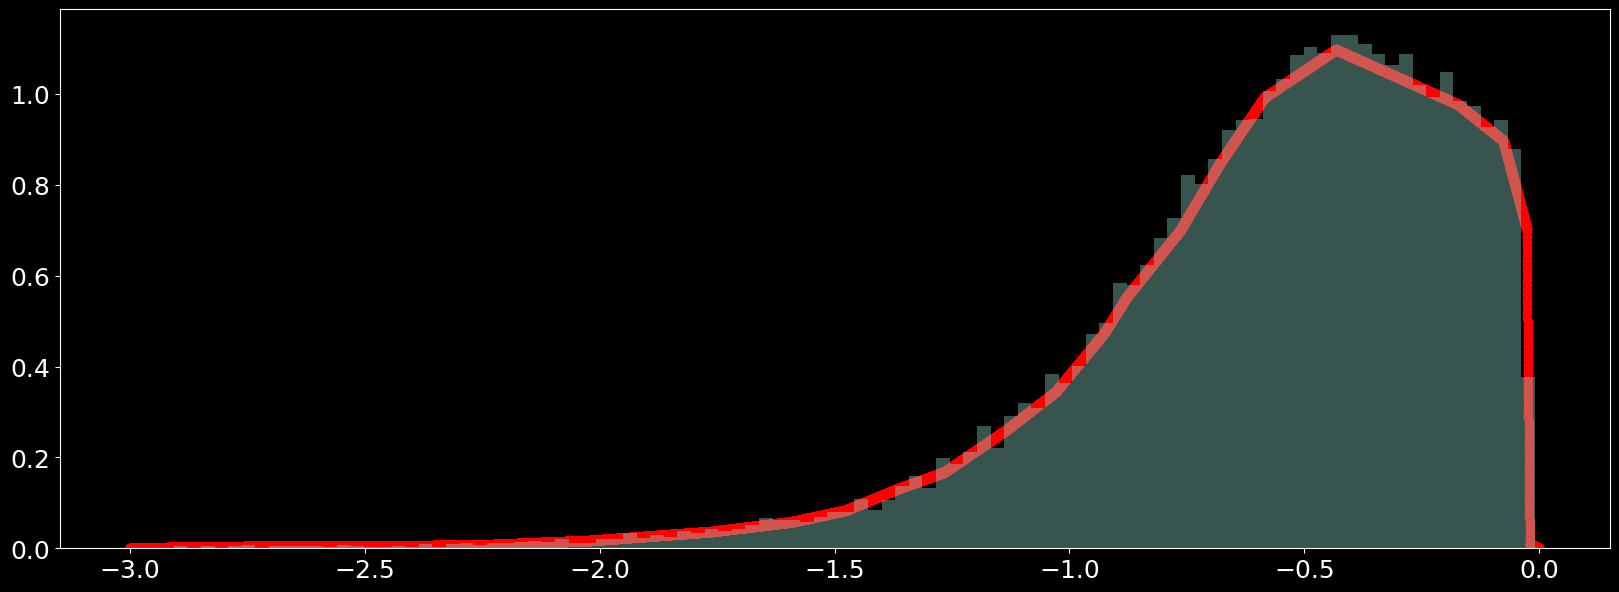

In [38]:
if not(bool(BNS)):
    print('Eccentricity at 10 Hz already provided in the paper for model = %s, \n No need of simulations for NSBH models' %model)
    
else:
    ecc_grid, ecc_interp, ecc_samples = ecc_sampling_func(ecc_min, ecc_max, ecc_0_file, ecc_spacing)
    print('No. of samples:', len(ecc_samples))

    #Belzynscki
    plt.scatter(ecc_grid, ecc_interp(ecc_grid)*10, color='red')
    plt.hist(ecc_samples, bins=100, density=True, alpha=0.4)
    plt.show()

    ## log(e) required for the diff equations later
    if bool(linear_ecc):
        ecc_samples = np.log10(ecc_samples)

### Get initial orbit-sep samples in terms of log(a)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:18<00:00, 2133.33it/s]


29992


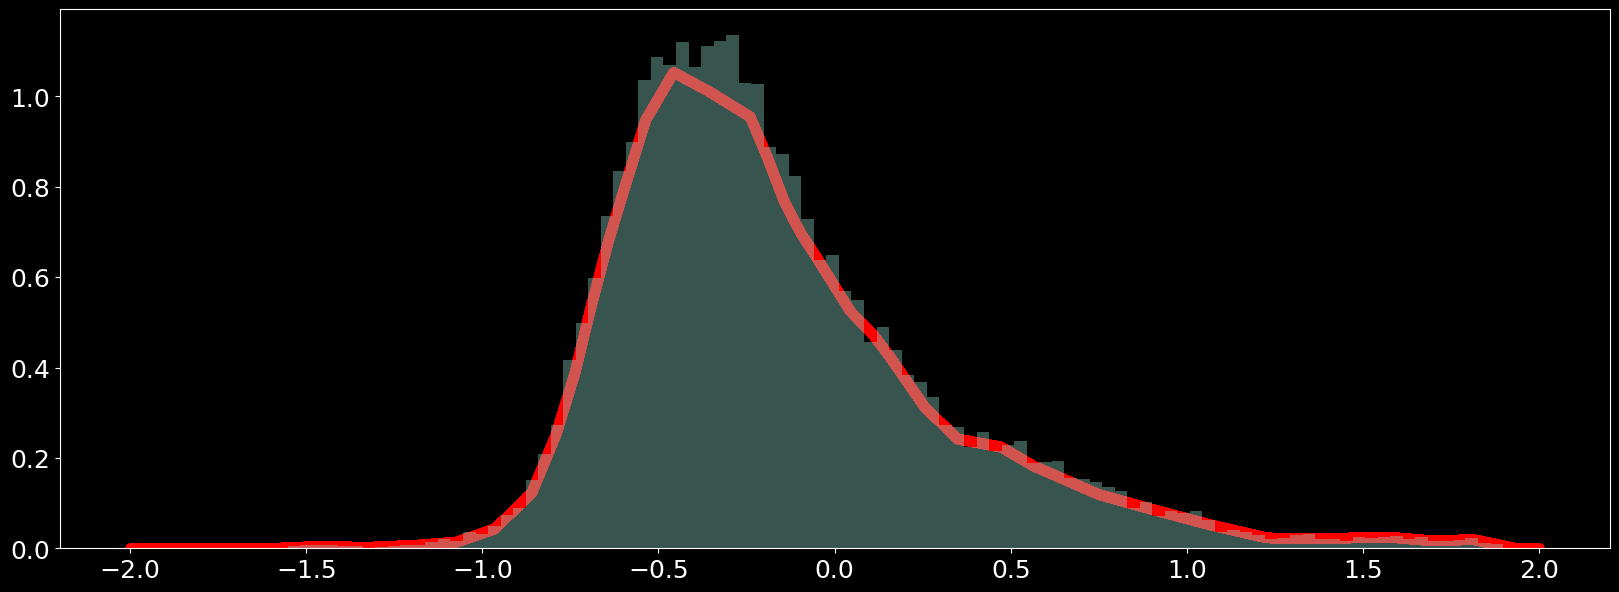

In [39]:
if not(bool(BNS)):
    print('Eccentricity at 10 Hz already provided in the paper for model = %s, \n No need of simulations for NSBH models' %model)
    
else:
    orb_grid, orb_interp, orb_samples = orb_sampling_func(orb_min, orb_max, orb_file, orb_spacing)
    orb_samples = orb_samples[:len(ecc_samples)]   
    
    #Belzynscki
    plt.scatter(orb_grid, orb_interp(orb_grid)*15, color='red')
    plt.hist(orb_samples, bins=100, density=True, alpha=0.4)

    #Trani
    #plt.scatter(orb_grid, orb_interp(orb_grid), color='red')
    #plt.hist(orb_samples, bins=100, density=True, alpha=0.4)

    #Fragione
    #plt.scatter(orb_grid, orb_interp(orb_grid), color='red')
    #plt.hist(orb_samples, bins=100, cumulative=True, density=True, alpha=0.4)


    if bool(linear_orb):
        orb_samples = np.log10(orb_samples)

    print(len(orb_samples))
    plt.show()    

### Extract the mass distributions -- (component masses or mchirp)

29992 29992 29992


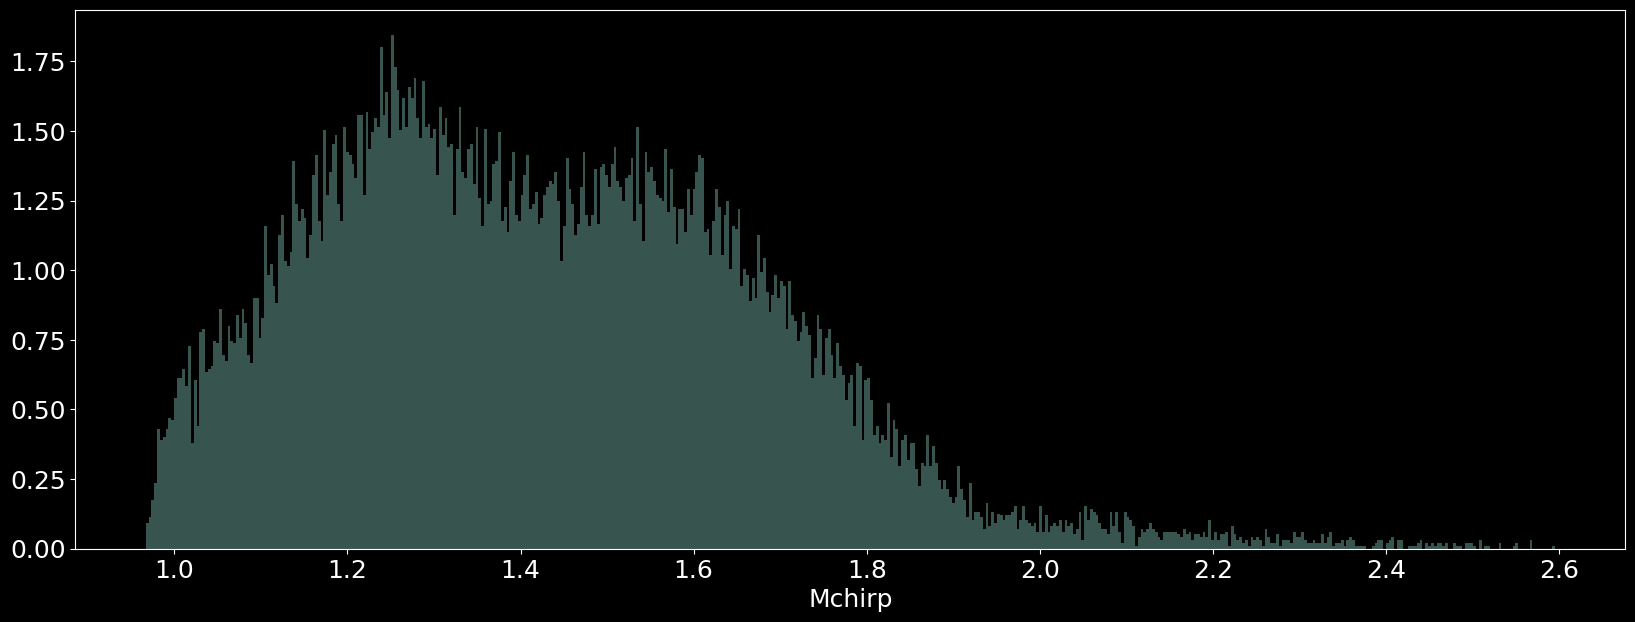

In [40]:
if model == 'belzynscki':
    m1_grid, m1_interp, m1_samples = mass_sampling_func(m_min, m_max, m1_file, mass_spacing)
    m2_grid, m2_interp, m2_samples = mass_sampling_func(m_min, m_max, m2_file, mass_spacing)

    m1_samples = m1_samples[:len(ecc_samples)]
    m2_samples = m2_samples[:len(ecc_samples)]

    mtotal_samples = m1_samples + m2_samples
    mchirp_samples = conversions.mchirp_from_mass1_mass2(m1_samples, m2_samples)

    #Belzynscki
    #plt.scatter(m1_grid, m1_interp(m1_grid)*10, color='red')
    plt.hist(mchirp_samples, bins=500, density=True, alpha=0.4)
    plt.xlabel('Mchirp')
    print(len(ecc_samples), len(orb_samples), len(mtotal_samples))

elif model == 'sedda':
    mchirp_grid, mchirp_interp, mchirp_samples = mass_sampling_func(mc_min, mc_max, mchirp_file, mc_spacing)
    plt.hist(mchirp_samples, bins=100, density=True, alpha=0.4)
    plt.xlabel('Mchirp')

elif model == 'trani':
    m1_grid, m1_interp, m1_samples = mass_sampling_func(m1_min, m1_max, m1_file, m1_spacing)
    m2_samples = np.random.uniform(1.0, 2.2, len(m1_samples))
    mchirp_samples = conversions.mchirp_from_mass1_mass2(m1_samples, m2_samples)
    plt.hist(mchirp_samples, bins=100, density=True, alpha=0.4)
    plt.xlabel('Mchirp')  

elif model == 'fragione':
    m1_grid, m1_interp, m1_samples = mass_sampling_func(m1_min, m1_max, m1_file, m1_spacing)
    m2_samples = np.full(len(m1_samples), 1.3)     ## Used for Fragionne-NSBH
    mchirp_samples = conversions.mchirp_from_mass1_mass2(m1_samples, m2_samples)
    plt.hist(mchirp_samples, bins=1000, density=True, alpha=0.4)
    plt.xlabel('Mchirp')
        
plt.show()

### Create a separate dictionary containing mtotal, orbital separation, natal eccentricity and c0 samples for BNS systems

In [41]:
if not(bool(BNS)):
    print('Eccentricity at 10 Hz already provided in the paper for model = %s, \n No need of simulations for NSBH models' %model)
    
else:
    def get_c0(loga, loge):
        '''
        Computes the constant c0 which relates the orbital separation and the eccentricity for a given system.
        This expression allows the orbital frequency to be in terms of eccentricity only. 
        
        !!! Make sure orb_samples and ecc_samples have only the exponent values !!!

        Parameters
        ----------
        loga : float
             Logarithm of the orbital separation
        loge : float
             Logarithm of the eccentricity 
             
        Returns
        -------
        float
            c0: The constant c0
        '''
        e = 10**(loge)
        a = 10**(loga)*sunr
        c0 = a*(1-e**2)/e**(12.0/19)/(1+121/304*e**2)**(870.0/2299)
        return c0

    def init_freq(a,e,M):
        freq = np.sqrt(G*M*MS)*(1+e)**(1.1954)/np.pi/(a*(1-e**2))**(1.5)
        return(freq)

    print("Double check the units of orb_samples")
    ## Creating the dictionary
    bns = {'mtotal': mtotal_samples, 'a': 10**orb_samples*(sunr), 'ecc': 10**ecc_samples, \
           'c0': get_c0(orb_samples, ecc_samples), 'f0': init_freq(10**orb_samples*(sunr),10**ecc_samples,mtotal_samples)}

Double check the units of orb_samples


### Compute the eccentricity evolution

In [42]:
#### Only the exponent of e goes into the function
def get_freq(e, mtotal, c0):
    '''
        Computes orbital frequency as a function of eccentricity for a given system -- Mtotal and orbital separation (in terms of c0)

        Parameters
        ----------
        ecc : float
             Eccentricity of the system
        mtotal : float
                The total mass of the system in Msun (e.g 2.8 Msun)
        c0 : float
            Constant relating the initial orbital separation and inital eccentricity for a given system. Check the get_c0 function or Peter's paper for reference.

        Returns
        -------
        float
            freq: Orbital frequency for the given eccentricity.
    '''
    M = mtotal*MS
    freq = np.sqrt(G*M)/np.pi*(1+e)**(1.1954)*e**(-18/19)*(1+121/304*e**2)**(-1305/2299)*c0**(-1.5)
    return freq

def get_ecc(freq, mtotal, ecc, c0):
    '''
        For a binary system with Mtotal and initial natal eccentricity and orbital separation. This function computes 
        the eccentricity as a function of orbital frequency.

        Parameters
        ----------
        freq : float
              The frequency (in Hz) at which the eccentricity is requested.
        mtotal : float
                The total mass of the system in Msun (e.g 2.8 Msun)
        ecc : float
             Initial eccentricity of the system
        c0 : float
            Constant relating the initial orbital separation and inital eccentricity for a given system. Check the get_c0 function or Peter's paper for reference.

        Returns
        -------
        float
            new_ecc: The old and new eccentricity at earlier and later frequencies respectively.
    '''
    new_ecc = []
    for k in tqdm(range(len(mtotal))):
        ecc_power = np.linspace(-9, np.log10(ecc[k]),1000)
        e = 10**ecc_power
        freqs = get_freq(e, mtotal[k], c0[k])
        ind = (np.abs(freqs-freq)).argmin()
        new_ecc.append(e[ind])    
    return ecc, new_ecc
                                
ecc, new_ecc10 = get_ecc(10, bns['mtotal'], bns['ecc'], bns['c0'])   

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 29992/29992 [00:07<00:00, 3866.72it/s]


### Plot the PDF of eccentricities at the formation and at later frequency

Fraction of sources with eccentricities > 0.01 at 10 Hz:  0.08335556148306214 %


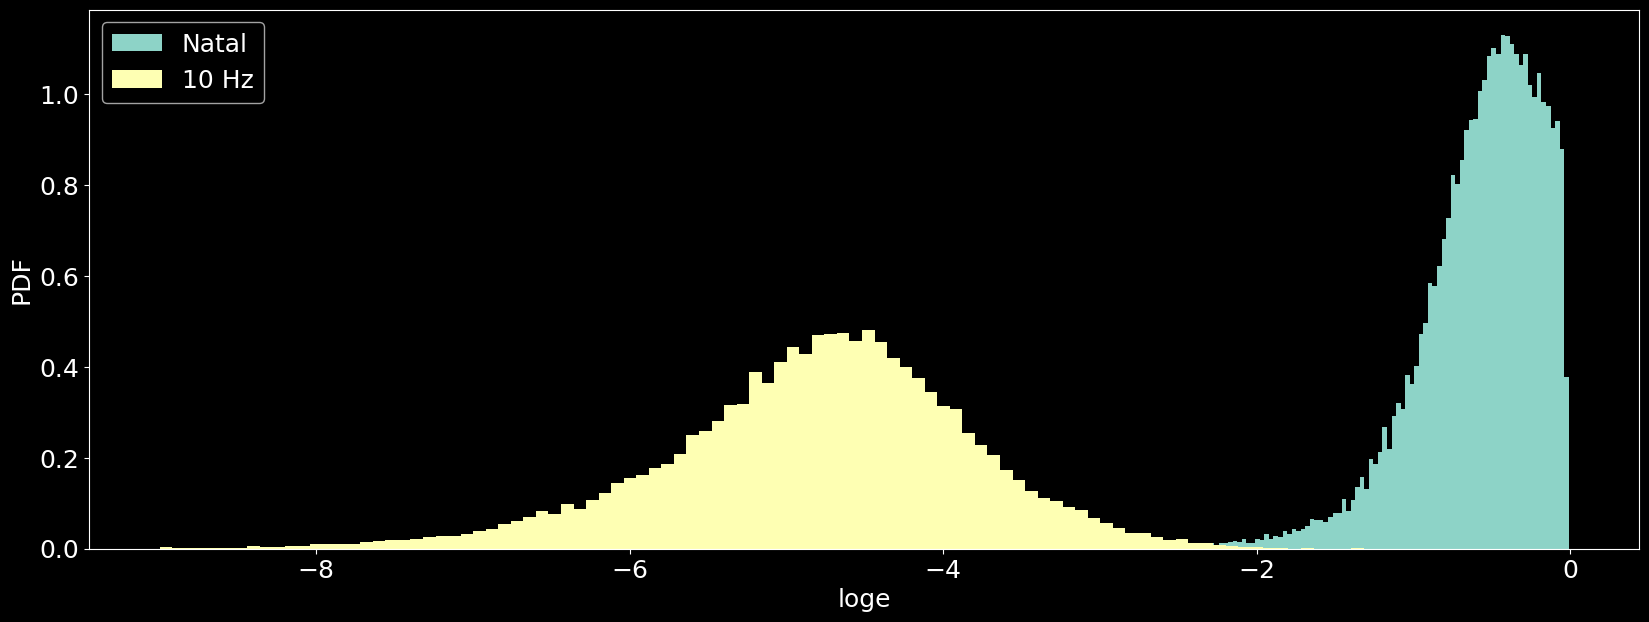

In [71]:
print('Fraction of sources with eccentricities > 0.01 at 10 Hz: ', len(np.where(np.array(new_ecc10) > 0.01)[0])/len(ecc)*100 ,'%')
plt.hist(np.log10(ecc), density=True, bins=100, label='Natal')
plt.hist(np.log10(new_ecc10), density=True, bins=100, label='10 Hz')
plt.xlabel('loge')
plt.ylabel('PDF')

plt.legend()
plt.show()

### Saving the eccentricity (10 Hz) samples to a .hdf file
-- Extract the ecc (10 Hz) samples directly in case of NSBH models

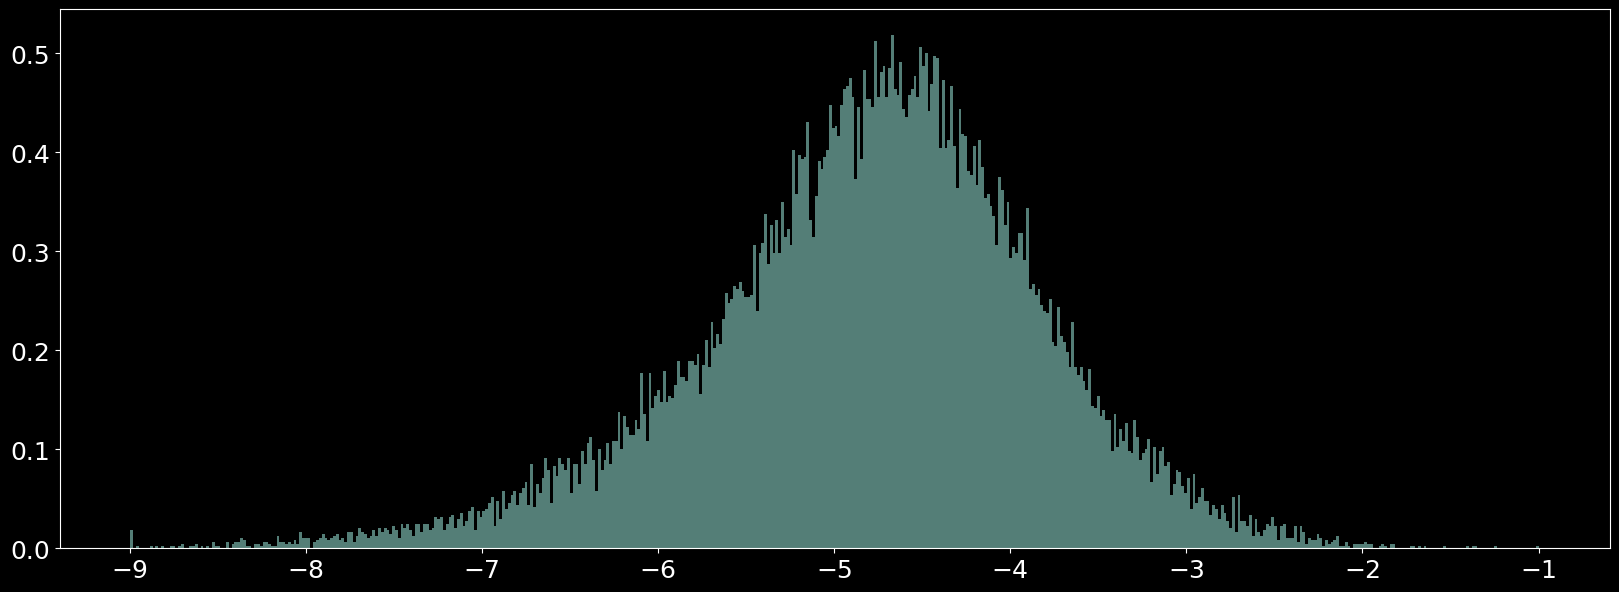

In [89]:
if not(bool(BNS)):
    # Extracts log(e)
    ecc10_grid, pdf_values, ecc10_samples = ecc_sampling_func(ecc_min, ecc_max, ecc_10_file, ecc_spacing)
    # Convert samples to e
    ecc10_samples = 10**ecc10_samples
    ecc10_grid = 10**ecc10_grid

else:
    ecc10_samples = new_ecc10
    pdf_values, ecc10_grid = np.histogram(ecc10_samples, density=True, bins=1000)

plt.hist(np.log10(ecc10_samples), density=True, alpha=0.6, bins=500)
plt.show()


## Original ecc grid and sample values are stored. No exponents
with h5py.File('pop-dist/bns/belzynski/ecc_10.hdf', 'w') as f:
    f.create_dataset("ecc_grid", data = np.array(ecc10_grid[:-1]))
    f.create_dataset("pdf_values", data = np.array(pdf_values))
    f.create_dataset("samples", data = np.array(ecc10_samples))
f.close()    

### Saving the mchirp samples to a .hdf file


In [36]:
hist, bins = np.histogram(mchirp_samples, density=True, bins=1000)

## Original ecc grid and sample values are stored, no exponents
with h5py.File('pop-dist/bns/belzynski/ez_mchirp.hdf', 'w') as f:
    f.create_dataset("mchirp_grid", data = np.array(bins[:-1]))
    f.create_dataset("pdf_values", data = np.array(hist))
    f.create_dataset("samples", data = np.array(mchirp_samples))
f.close()
print('Storing mchirp from', min(mchirp_samples), max(mchirp_samples))

Storing mchirp from 0.9666246103918609 2.5821460015106283
